<a href="https://colab.research.google.com/github/jingyi0936/CSE-416/blob/master/Deep_Learning_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Deep Learning

This assignment will give you practice using the library [Keras](https://keras.io/), which is a popular library for getting started with deep learning models. Deep Learning is a very powerful tool because it is able to learn very complicated functions. Deep Learning has revolutionized fields like image and speech recognition.

The specific task we are trying to solve in this assignment is image classification. We will be using a very commong dataset called CIFAR-10 that has 60,000 images separated into 10 classes. The classes are

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck
In this assignment, you will practice:

Reading documentation for a modern machine learning library
Writing Keras code.
Evaluating neural network models.
Fill in the cells provided marked TODO with code to answer the questions. Unless otherwise noted, every answer you submit should have code that clearly shows the answer in the output. Answers submitted that do not have associated code that shows the answer may not be accepted for credit.

Make sure to restart the kernel and run all cells (especially before turning it in) to make sure your code runs correctly. Answer the questions on Gradescope and make sure to upload your notebook to the upload section.

Copyright ©2020 Hunter Schafer and Valentina Staneva. Hunter Schafer wrote the original PyTorch version of this exercise. Valentina Staneva wrote the Keras version of the exercise. All rights reserved. Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Spring Quarter 2020 for purposes of the course. No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored. Instructors interested in reusing these course materials should contact the author.

## Step 1 - Background Reading
Before starting this assignment, you should familiarize yourself with Keras. Review the notebooks from the section: [nn_notebook](https://drive.google.com/file/d/1WzM0eSogowR6bVqIrvE55wS4-OyRJ87F/view) and [cnn_notebook](https://drive.google.com/file/d/1iccoUX-HumXNxcCRXW-7msh3vZdwJ6_0/view). 

Spend also some time to read this Keras Guide: 
[Introduction to Keras for Engineers](https://keras.io/getting_started/intro_to_keras_for_engineers/)

Skim through the sections at least up to **Using callbacks for checkpointing (and more)**.
That will help you know where to go back if something is unlcear. There is also an associated Colab notebook. 
 
You can also rely on the documentation of the individual functions you are using to see their input-output requirements.

Assignment
Before you start, make sure you have enabled GPU for your Colab Runtime. In the Runtime drop down above, click on "Change runtime type" and select "GPU" in the Hardware Accelerator field.

First we import all of the modules we will use in this assignment.

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

Using TensorFlow backend.


Then we define some constants that will be used throughout the program.

In [ ]:
INPUT_SIZE    = 3 * 32 * 32   # An image has 32 x 32 pixels each with Red/Green/Blue values. 
NUM_CLASSES   = 10            # The number of output classes. In this case, from 0 to 9
NUM_EPOCHS    = 10            # The number of times we loop over the whole dataset during training
BATCH_SIZE    = 32            # The size of input data took for one iteration of an epoch
LEARNING_RATE = 1e-4          # The speed of convergence

The first step is to download the dataset using Keras. The dataset is built-in keras so we do not need a link to access. The code below produces a train set and a test set. This is actually pretty similar to `scikit-learn`. We will also convert the labels to a vector with 10 categories.
  

In [ ]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

170500096/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Now that you have split the test and train data, do a second split into train and validation (4:1 ratio).  You can simply call the `scikit-learn` `train_test_split` function for that and call the new validation variables `x_val` and `y_val`. Use `random_state=1`.

In [ ]:
# TODO
# create the x_val and y_val datasets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size = 0.2, random_state = 1)
print(len(x_train)) # 40000
len(y_val) # 10000

40000


10000

We will later use the validation set while training the network. After each epoch on can evaluate the model on the validation set to check if the performance starts to deteorate. This is built-in `keras`. One just needs to pass it in the `fit` function.

<Figure size 36x36 with 0 Axes>

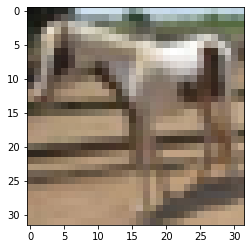

<Figure size 36x36 with 0 Axes>

In [ ]:
# look at an image
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
plt.figure(figsize = (0.5,0.5))

In [ ]:
# We will also convert the images to float and will divide by 255 so that the values are between (0,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_test /= 255
x_val /= 255

The function below is a generic function to train any model and store the history of training. 

In [ ]:
def train_model(model, x_train, y_train, x_val, y_val,
          num_epochs=NUM_EPOCHS, batch_size = BATCH_SIZE, learning_rate=LEARNING_RATE):
  
  # we will train the model with the RMSprop algorithm
  opt = keras.optimizers.RMSprop(learning_rate=learning_rate, decay=1e-6)

  # we will use the crossentropy cost, and will look at the accuracy
  model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
  
  # here we fit the model
  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=num_epochs,
            validation_data=(x_val, y_val),
            shuffle=False)
  
  return(model, history)


## Step 2
To use the functions above we need to define some neural network models to train. Since we are trying to solve a classification problem with 10 classes all models should have a Softmax Activation to connect the last layer with the Classes. [Softmax] is the extension of the logistic sigmoid function for multiple classes. 

### `NetA`
The first neural network will be the simplest, in that it has no hidden layers. It should take the image and flatten it to a vector for the input, and then have 10 outputs, one for each class. That should be a familiar linear classifier.



### `NetB`
The second neural network will be slightly more complicated in that it has a hidden layer with 300 nodes and adds a non-linearity between the layers. It should use the following operations in this order:
* Flatten the image to a vector for the input
* Use a fully-connected linear layer with 300 hidden-neurons
* Use the ReLU activation function
* Use a fully-connected layer to the 10 outputs.

### `NetC`
This third neural network will be a convolutional neural network. It should use the following operations in this order: 
* Use a convolution layer with kernel-width 5, depth 25, and padding `same`
* Use the ReLU activation function
* Use a max-pool operation with kernel-width 2 and stride 2
* Flatten the image to a vector for the next step's input
* Use a fully-connected layer to the 10 outputs.

This architecture can be seen visually in the following diagram (the left-most object is the input image). 

![Network Architecture](https://courses.cs.washington.edu/courses/cse416/19su/files/assignment-resources/homework/hw7/nn.svg)

Notice that these diagrams use the notation 
```
channels @ height x width
``` 
to describe the dimensions of the results at each step.

### `NetD`
This is your chance to try out some different architectures of your choice. Create your own neural network architecture that has **at least 2 convolution layers** and **at least 2 fully connected layers**. Can you find a network architecture that achieves at least 60% test accuracy. Most of the points for this problem are based on having a model that meets the minimum layer requirements, with fewer points focusing on the accuracy.

*Implementation details/notes*:
* For simplicity, your model should be able to be trained with the same learning rate and optimizer as the other models. This is a restriction that is not normal in real-practice, but we want you to follow this to simplify the code and our grading. 
* Every convolution operation should be followed by a pooling operation. 
* Every linear layer and convolution layer should have an activation function. Exception is the last layer which is connected to the classes via the Softmax Activation Function.
* You will likely want to use `NetC` as a starting point! 
* It is not required, but it might help to make your code more modular by adding parameters to the funciton to specify numbers that contain details about the architecture. Then you can automate trying many different settings of these hyper-parameters. 

In [ ]:
# TODO
# Write definitions for the 4 models. Write the definition cleanly with a label in a separate cell. 
# To run initialize it multiple times you might want to define functions like:

#def netA():
#
 # return(model)
#print(x_train.shape[1:])

In [ ]:
# model A
def netA():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(y_train.shape[1]))
  model.add(Activation('softmax'))
  return (model)

In [ ]:
result = train_model(netA(), x_train, y_train, x_val, y_val, num_epochs = NUM_EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 6s 144us/step - loss: 2.0072 - accuracy: 0.2826 - val_loss: 1.9137 - val_accuracy: 0.3241
Epoch 2/10
40000/40000 [==============================] - 4s 103us/step - loss: 1.8673 - accuracy: 0.3458 - val_loss: 1.8623 - val_accuracy: 0.3455
Epoch 3/10
40000/40000 [==============================] - 4s 102us/step - loss: 1.8299 - accuracy: 0.3607 - val_loss: 1.8381 - val_accuracy: 0.3556
Epoch 4/10
40000/40000 [==============================] - 4s 103us/step - loss: 1.8085 - accuracy: 0.3701 - val_loss: 1.8231 - val_accuracy: 0.3609
Epoch 5/10
40000/40000 [==============================] - 4s 101us/step - loss: 1.7935 - accuracy: 0.3776 - val_loss: 1.8124 - val_accuracy: 0.3662
Epoch 6/10
40000/40000 [==============================] - 4s 101us/step - loss: 1.7821 - accuracy: 0.3825 - val_loss: 1.8043 - val_accuracy: 0.3697
Epoch 7/10
40000/40000 [==============================] - 4s 1

In [ ]:
result[0].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                30730     
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model B
def netB():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(300))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  
  return (model)

In [ ]:
result_B = train_model(netB(), x_train, y_train, x_val, y_val, num_epochs = NUM_EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 5s 120us/step - loss: 1.8997 - accuracy: 0.3165 - val_loss: 1.8604 - val_accuracy: 0.3339
Epoch 2/10
40000/40000 [==============================] - 5s 118us/step - loss: 1.7294 - accuracy: 0.3856 - val_loss: 1.7629 - val_accuracy: 0.3642
Epoch 3/10
40000/40000 [==============================] - 5s 119us/step - loss: 1.6541 - accuracy: 0.4146 - val_loss: 1.7225 - val_accuracy: 0.3807
Epoch 4/10
40000/40000 [==============================] - 5s 118us/step - loss: 1.6024 - accuracy: 0.4349 - val_loss: 1.6794 - val_accuracy: 0.3960
Epoch 5/10
40000/40000 [==============================] - 5s 120us/step - loss: 1.5615 - accuracy: 0.4502 - val_loss: 1.6529 - val_accuracy: 0.4035
Epoch 6/10
40000/40000 [==============================] - 5s 119us/step - loss: 1.5259 - accuracy: 0.4642 - val_loss: 1.6352 - val_accuracy: 0.4115
Epoch 7/10
40000/40000 [==============================] - 5s 1

In [ ]:
result_B[0].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               921900    
_________________________________________________________________
activation_2 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                3010      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 924,910
Trainable params: 924,910
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model C
def netC():
  # define the keras model
  model = Sequential()
  model.add(Conv2D(25, (5, 5), padding = 'same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('softmax'))
  return (model)


In [ ]:
result_C = train_model(netC(), x_train, y_train, x_val, y_val, num_epochs = NUM_EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 6s 139us/step - loss: 1.8789 - accuracy: 0.3446 - val_loss: 1.7090 - val_accuracy: 0.4012
Epoch 2/10
40000/40000 [==============================] - 6s 138us/step - loss: 1.6273 - accuracy: 0.4373 - val_loss: 1.5686 - val_accuracy: 0.4448
Epoch 3/10
40000/40000 [==============================] - 5s 136us/step - loss: 1.5169 - accuracy: 0.4743 - val_loss: 1.4865 - val_accuracy: 0.4756
Epoch 4/10
40000/40000 [==============================] - 5s 137us/step - loss: 1.4450 - accuracy: 0.4992 - val_loss: 1.4309 - val_accuracy: 0.4947
Epoch 5/10
40000/40000 [==============================] - 5s 136us/step - loss: 1.3932 - accuracy: 0.5168 - val_loss: 1.3912 - val_accuracy: 0.5096
Epoch 6/10
40000/40000 [==============================] - 5s 137us/step - loss: 1.3540 - accuracy: 0.5317 - val_loss: 1.3614 - val_accuracy: 0.5214
Epoch 7/10
40000/40000 [==============================] - 5s 1

In [ ]:
result_C[0].summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 25)        1900      
_________________________________________________________________
activation_64 (Activation)   (None, 32, 32, 25)        0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 25)        0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 10)                64010     
_________________________________________________________________
activation_65 (Activation)   (None, 10)                0         
Total params: 65,910
Trainable params: 65,910
Non-trainable params: 0
_________________________________________________

In [ ]:
# model D
def netD():
  model = Sequential()
  model.add(Conv2D(25, (5, 5), padding = 'same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Conv2D(25, (5, 5), padding = 'same'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dense(400))
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('softmax'))
  return (model)

In [ ]:
result_D = train_model(netD(), x_train, y_train, x_val, y_val, num_epochs = NUM_EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 6s 162us/step - loss: 1.7405 - accuracy: 0.3843 - val_loss: 1.5465 - val_accuracy: 0.4452
Epoch 2/10
40000/40000 [==============================] - 6s 157us/step - loss: 1.4605 - accuracy: 0.4855 - val_loss: 1.4161 - val_accuracy: 0.4882
Epoch 3/10
40000/40000 [==============================] - 7s 165us/step - loss: 1.3418 - accuracy: 0.5292 - val_loss: 1.3329 - val_accuracy: 0.5213
Epoch 4/10
40000/40000 [==============================] - 7s 167us/step - loss: 1.2630 - accuracy: 0.5591 - val_loss: 1.2698 - val_accuracy: 0.5446
Epoch 5/10
40000/40000 [==============================] - 6s 155us/step - loss: 1.2002 - accuracy: 0.5818 - val_loss: 1.2174 - val_accuracy: 0.5659
Epoch 6/10
40000/40000 [==============================] - 6s 154us/step - loss: 1.1473 - accuracy: 0.6011 - val_loss: 1.1739 - val_accuracy: 0.5833
Epoch 7/10
40000/40000 [==============================] - 6s 1

In [ ]:
result_D[0].summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 25)        1900      
_________________________________________________________________
activation_35 (Activation)   (None, 32, 32, 25)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 25)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 25)        15650     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 25)          0         
_________________________________________________________________
dense_24 (Dense)             (None, 8, 8, 400)         10400     
_________________________________________________________________
activation_36 (Activation)   (None, 8, 8, 400)       

**Gradescope Q1** 

Use the `model.summary` function to extract how many parameters models A, B, C have. Enter the numbers on Gradescope.

## STEP 3 
Now it is time to use these models to loop through all the four models and store and compare their training performance. After training each model display the test accuracy. 

In [ ]:
# TODO
# write a loop to train all 4 models and save the history in a list/dictionary.
# print out the test accuracy for each model
historyy = []
total_net = [netA(), netB(), netC(), netD()]
for i in range(4):
  ans = train_model(total_net[i], x_train, y_train, x_val, y_val, num_epochs = NUM_EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)
  historyy.append(ans[1])

  perform = ans[0].evaluate(x_test, y_test)
  print("Test accuracy is ", perform[1])

# For netD: Test accuracy is  0.6171000003814697

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 4s 102us/step - loss: 1.9992 - accuracy: 0.2833 - val_loss: 1.9151 - val_accuracy: 0.3221
Epoch 2/10
40000/40000 [==============================] - 4s 102us/step - loss: 1.8667 - accuracy: 0.3446 - val_loss: 1.8637 - val_accuracy: 0.3453
Epoch 3/10
40000/40000 [==============================] - 4s 101us/step - loss: 1.8294 - accuracy: 0.3598 - val_loss: 1.8394 - val_accuracy: 0.3548
Epoch 4/10
40000/40000 [==============================] - 4s 100us/step - loss: 1.8080 - accuracy: 0.3701 - val_loss: 1.8243 - val_accuracy: 0.3604
Epoch 5/10
40000/40000 [==============================] - 4s 101us/step - loss: 1.7931 - accuracy: 0.3780 - val_loss: 1.8136 - val_accuracy: 0.3624
Epoch 6/10
40000/40000 [==============================] - 4s 101us/step - loss: 1.7817 - accuracy: 0.3824 - val_loss: 1.8054 - val_accuracy: 0.3659
Epoch 7/10
40000/40000 [==============================] - 4s 1

**Gradescope Q2** 

Enter the test accuracies for each model on Gradescope.

Explore the history object for the models, and extract the train and validation accuracies. Plot them on the same graph with respect to changing epochs with the corresponding legend.

In [ ]:
# TODO
# plot all 4 validation accuracies and train accuracies on the same plot with an appropriate legend 
# make sure you have different colors for different models
# make the the validation dashed line
# the axes should be Epochs & Accuracy
# you should have total of 8 curves
historyy[0].history['accuracy']
historyy[0].history['val_accuracy']

[0.3221000134944916,
 0.34529998898506165,
 0.3547999858856201,
 0.36039999127388,
 0.36239999532699585,
 0.3659000098705292,
 0.36959999799728394,
 0.37220001220703125,
 0.37470000982284546,
 0.3767000138759613]

The pieces of function below might be helpful, but feel free to create the plot in your way, just following the above rules.

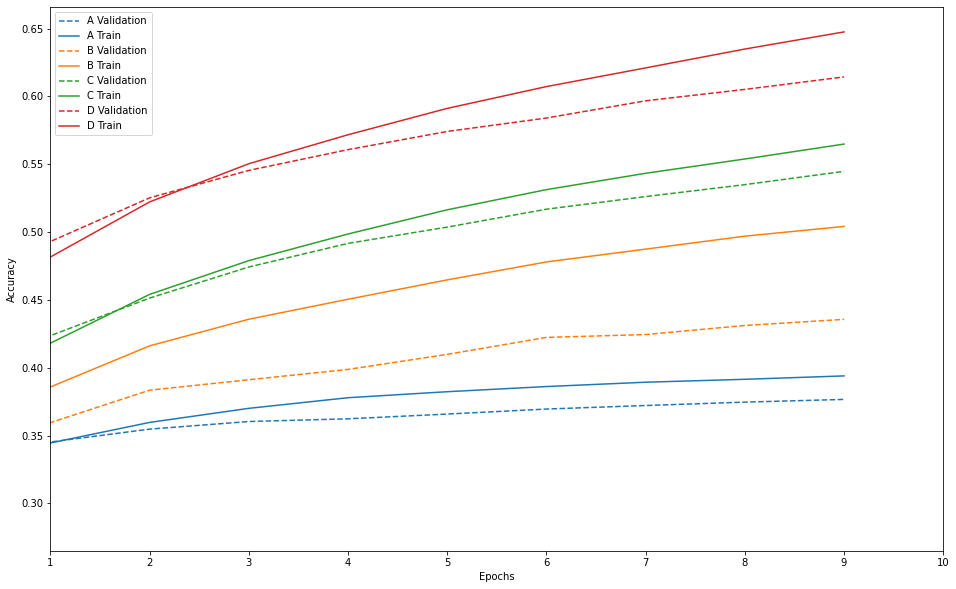

In [ ]:
## TODO
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
model_labels = 'ABCD'
for i in range(4):

    name = model_labels[i]
    val = plt.plot(historyy[i].history['val_accuracy'],
                     '--', label= name + ' Validation')
    plt.plot(historyy[i].history['accuracy'],
             color=val[0].get_color(),label= name + ' Train')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,NUM_EPOCHS])